# Task 4: Statistical Modeling and Evaluation

In this notebook, we build and evaluate predictive models for a dynamic, risk-based pricing system.

## Objectives
1.  **Claim Severity Prediction (Regression)**: Predict `TotalClaims` for policies with a claim.
2.  **Claim Probability Prediction (Classification)**: Predict the likelihood (`IsClaim`) of a claim occurring.
3.  **Interpretability**: Use SHAP values to explain the key drivers of risk.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Ensure src modules are importable
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data.loader import load_data
from src.features.build_features import DataBuilder
from src.models.train_model import ModelTrainer

# Output Setup
sns.set_style("whitegrid")
%matplotlib inline

## 1. Data Loading & Preparation
We load the raw data and pass it through our `DataBuilder` pipeline.

In [2]:
DATA_PATH = '../data/raw/MachineLearningRating.txt'
if not os.path.exists(DATA_PATH):
    DATA_PATH = 'data/raw/MachineLearningRating.txt'

df_raw = load_data(DATA_PATH)
print(f"Raw Data Shape: {df_raw.shape}")

Raw Data Shape: (1000098, 52)


In [3]:
# Initialize and Run Preprocessing Pipeline
builder = DataBuilder(df_raw)
df_processed = builder.preprocess()

print(f"Processed Data Shape: {df_processed.shape}")
df_processed.head()

2025-12-08 01:03:42,036 - INFO - Starting preprocessing pipeline...


2025-12-08 01:03:42,036 - INFO - Engineering features...


2025-12-08 01:03:42,082 - INFO - Handling missing values...


2025-12-08 01:03:56,936 - INFO - Encoding categorical variables...


2025-12-08 01:04:03,618 - INFO - Preprocessing pipeline complete.


Processed Data Shape: (1000098, 55)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,IsClaim,VehicleAge,Premium_Risk_Ratio
0,145249.0,12827.0,17,True,0,0,2,0,2,0,...,5,1,2,0,0,21.929825,0.0,0.0,21.0,2192.763180
1,145249.0,12827.0,19,True,0,0,2,0,2,0,...,5,1,2,0,0,21.929825,0.0,0.0,21.0,2192.763180
2,145249.0,12827.0,21,True,0,0,2,0,2,0,...,5,1,2,0,0,0.000000,0.0,0.0,21.0,0.000000
3,145255.0,12827.0,19,True,0,0,2,0,2,0,...,5,1,2,0,0,512.848070,0.0,0.0,21.0,0.004299
4,145255.0,12827.0,21,True,0,0,2,0,2,0,...,5,1,2,0,0,0.000000,0.0,0.0,21.0,0.000000


## 2. Model 1: Claim Severity (Regression)
**Goal**: Predict `TotalClaims` amount using only positive claim cases.

In [4]:
# Get specific dataset for Severity
X_severity, y_severity = builder.get_severity_data()
print(f"Severity Dataset: {X_severity.shape}")

# Split
X_train_sev, X_test_sev, y_train_sev, y_test_sev = builder.split_data(X_severity, y_severity)

# Initialize Trainer
trainer = ModelTrainer()

# Train Regression Models
trainer.train_severity_models(X_train_sev, X_test_sev, y_train_sev, y_test_sev)

2025-12-08 01:04:03,664 - INFO - Training Severity Models (Regression)...


2025-12-08 01:04:03,674 - INFO - [LinearRegression] RMSE: 33634.29, R2: 0.2966


Severity Dataset: (2788, 52)


2025-12-08 01:04:04,590 - INFO - [RandomForest_Reg] RMSE: 36790.48, R2: 0.1584


2025-12-08 01:04:04,867 - INFO - [XGBoost_Reg] RMSE: 38390.72, R2: 0.0836


## 3. Model 2: Claim Probability (Classification)
**Goal**: Predict binary probability of a claim occurring (`IsClaim=1`).

In [5]:
# Get specific dataset for Probability
X_prob, y_prob = builder.get_probability_data()
print(f"Probability Dataset: {X_prob.shape}")

# Split
X_train_prob, X_test_prob, y_train_prob, y_test_prob = builder.split_data(X_prob, y_prob)

# Train Classification Models
trainer.train_probability_models(X_train_prob, X_test_prob, y_train_prob, y_test_prob)

Probability Dataset: (1000098, 52)


2025-12-08 01:04:06,682 - INFO - Training Probability Models (Classification)...


C:\Users\hp\Downloads\KAIM\KAIM W3\Insurance-claims-Intelligence\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025-12-08 01:08:01,785 - INFO - [LogisticRegression] Accuracy: 0.8590, F1-Score: 0.0303


2025-12-08 01:09:33,417 - INFO - [RandomForest_Clf] Accuracy: 0.9962, F1-Score: 0.0155


C:\Users\hp\Downloads\KAIM\KAIM W3\Insurance-claims-Intelligence\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:09:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


2025-12-08 01:09:41,477 - INFO - [XGBoost_Clf] Accuracy: 0.8645, F1-Score: 0.0367


## 4. Model Evaluation & Comparison

,RMSE,R2,Accuracy,F1
LinearRegression,33634.288749,0.296585,NaN,NaN
RandomForest_Reg,36790.479887,0.158376,NaN,NaN
XGBoost_Reg,38390.722098,0.083569,NaN,NaN
LogisticRegression,NaN,NaN,0.858984,0.030255
RandomForest_Clf,NaN,NaN,0.996195,0.015524
XGBoost_Clf,NaN,NaN,0.864519,0.036686


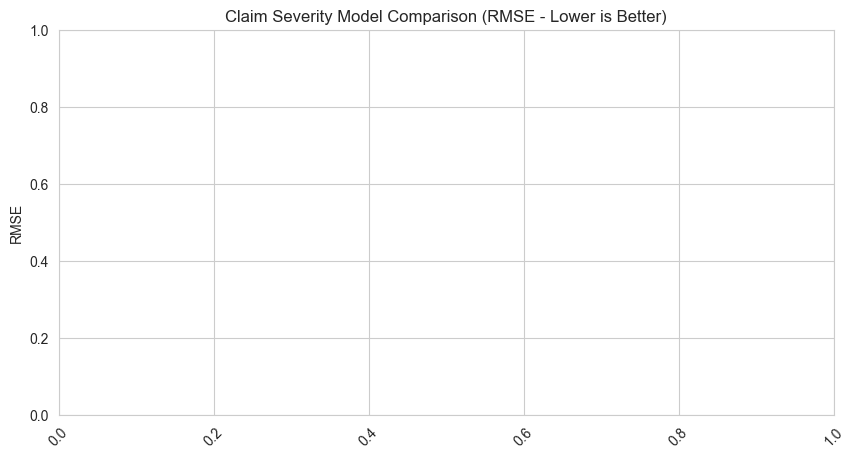

In [6]:
results = trainer.get_results()
display(results)

# Visualize RMSE for Regression
plt.figure(figsize=(10, 5))
reg_res = results[results.index.str.contains("Severity")]
sns.barplot(x=reg_res.index, y=reg_res['RMSE'], palette='viridis')
plt.title("Claim Severity Model Comparison (RMSE - Lower is Better)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

## 5. Model Interpretability (SHAP)
We analyse the best performing model (typically XGBoost) to understand feature importance.

Interpreting XGBoost Classification with SHAP...


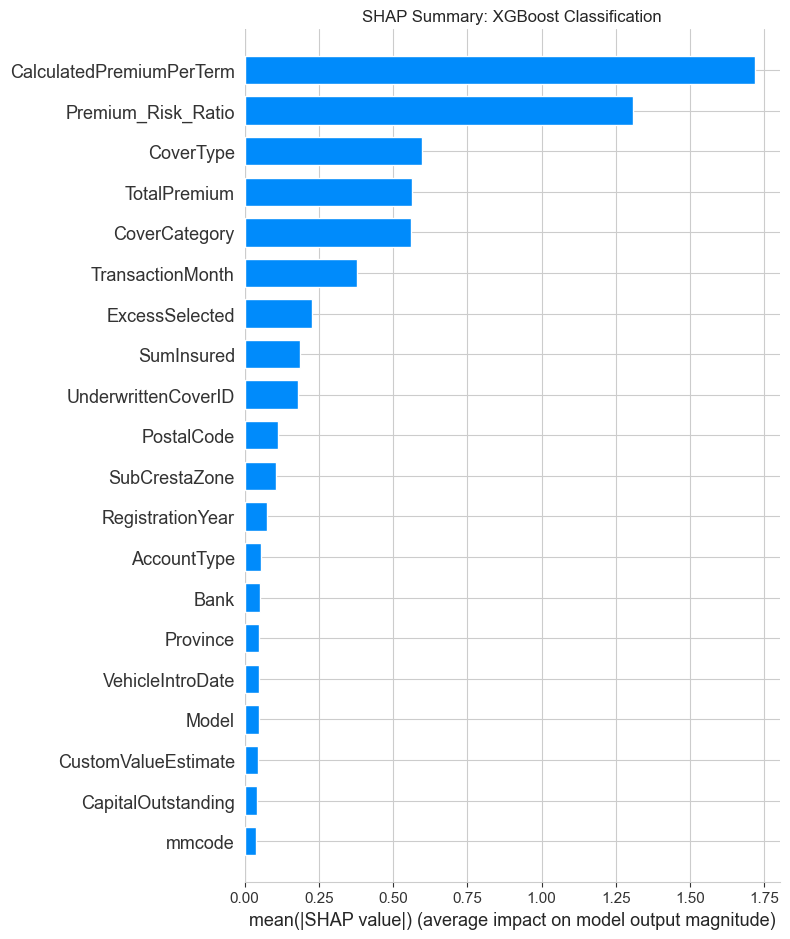

Detailed Feature Impact:


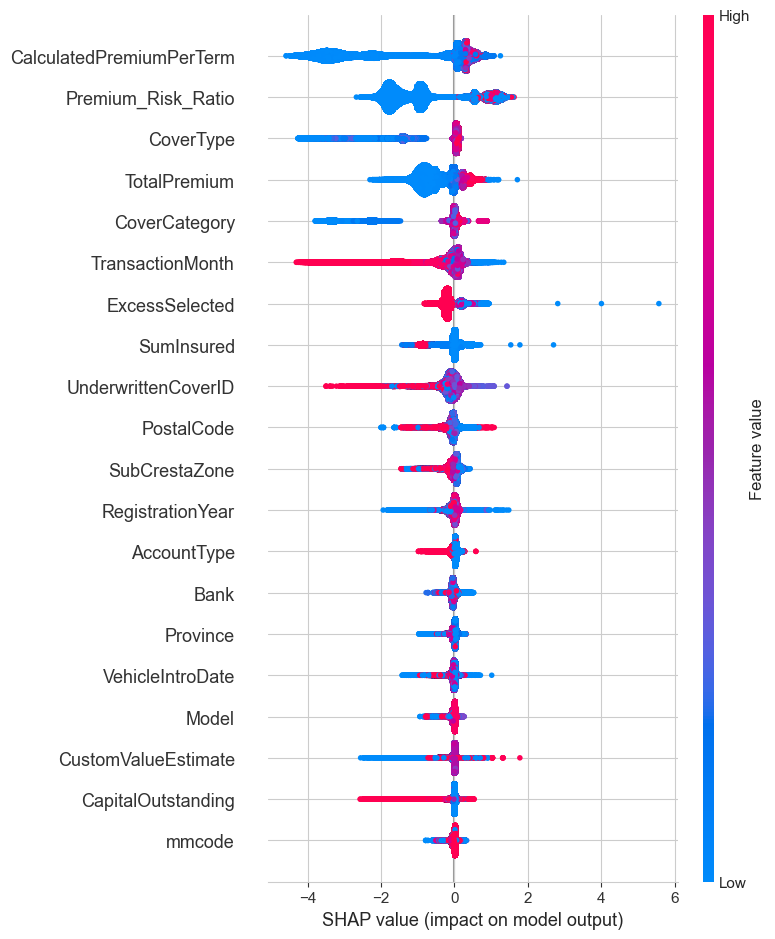

In [7]:
def interpret_model(model, X_train, model_name):
    print(f"Interpreting {model_name} with SHAP...")
    try:
        # Use TreeExplainer for Tree models
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        
        plt.title(f"SHAP Summary: {model_name}")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        plt.show()
        
        print("Detailed Feature Impact:")
        shap.summary_plot(shap_values, X_train)
    except Exception as e:
        print(f"SHAP failed: {e}")
        # Fallback to feature importance
        if hasattr(model, 'feature_importances_'):
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            feat_importances.nlargest(10).plot(kind='barh')
            plt.title("Feature Importance (Fallback)")
            plt.show()

# Interpret best Probability Model (e.g., XGBoost)
if 'Probability_XGB' in trainer.models:
    interpret_model(trainer.models['Probability_XGB'], X_train_prob, "XGBoost Classification")
elif 'Probability_RF' in trainer.models:
    interpret_model(trainer.models['Probability_RF'], X_train_prob, "RandomForest Classification")

## 6. Conclusion
The analysis provides a dual-framework for pricing:
1.  **Risk Probability**: Identified drivers of *accident frequency*.
2.  **Risk Severity**: Identified drivers of *cost* when accidents occur.

By combining these, we can formulate an optimal premium:
> **Premium** = (P(Claim) * E[Claim Cost]) + Margin